In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/33/116sfqg91_505ryh1n1c87x00000gp/T/ipykernel_4224/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Light curve in single lens microlensing events

In the case of a galactic microlensing event prouduced by a single lens, the Einstein radius is
$$
\theta_E\approx 1 mas \left(\frac{M}{M_\odot}\right)^{1/2}\left(\frac{D}{10 \mathrm{kpc}}\right)^{-1/2} \;.
$$
Since this is the scale of separation between the images in the microlensing event, we may conclude that the effect is not appreciable.

However, if the source moves in lens centered coordinates with some transverse velocity $v$ or relative motion
$$
\mu_{rel}=\frac{v}{D_L} \;,
$$
then, during the microlensing event, the magnification of the source changes as
$$
\mu(t)=\frac{y^2(t)+2}{y(t)\sqrt{y^2(t)+4}}
$$
with 
$$
y(t)=\sqrt{y_0^2+\left(\frac{t-t_0}{t_E}\right)^2} \;.
$$

The quantity $t_E$ is the Einstein crossing time
$$
t_E = \frac{D_L\theta_E}{v} = \frac{\theta_E}{\mu_{rel}}
$$
which is of order
$$
t_E\approx 19\; \mathrm{days} \; \sqrt{4\frac{D_{L}}{D_{S}}\left(1-\frac{D_{L}}{D_{S}}\right)}\left(\frac{D_{S}}{8 \mathrm{kpc}}\right)^{1/2}\left(\frac{M}{0.3 M_\odot}\right)^{1/2}\left(\frac{v}{200 \mathrm{km}/s}\right)^{-1}
$$

In the following, we will compute amplitude of the effect, to understand if it is measurable.

We define two python classes, one for the source and one for the lens. The first is very simple:

In [2]:
from astropy import constants as const 
from astropy import units as u
import numpy as np

class point_source(object):
    
    def __init__(self,flux=1.0,ds=10.0,vel=200.):
        """
        Initialize a point source.
        Parameters:
        - flux: baseline flux
        - ds: source distance
        - vel: source relative velocity
        """
        self.ds=ds
        self.flux=flux
        self.vel=vel

We create a ```point_source``` by specifying its baseline flux, distance and relative velocity.

The second class, ```point_lens```, contains several methods that implements the formulas shown above:

In [3]:
class point_lens(object):

    """ 
    Initialize a point lens.
    Parameters:
    - ps : point source
    - mass : lens mass
    - dl : lens distance
    - t0 : time of minimal distance from the source
           (magnification peak)
    - y0 : impact parameter
    """
    def __init__(self,ps,mass=1.0,dl=5.0,ds=8.0,t0=0.0,y0=0.1):
        self.M=mass
        self.dl=dl
        self.ps=ps
        self.y0=y0
        self.t0=t0
        self.tE=self.EinsteinCrossTime()
        
###################################################################        
    # a function returning the Einstein radius
    def EinsteinRadius(self):
        mass=self.M*const.M_sun
        G=const.G
        c=const.c
        # conversion factor: radian to arcsec 
        aconv=np.rad2deg(1.0)*3600.0*u.arcsecond 
        return((np.sqrt(4.0*(G*mass/c/c).to('kpc')*(self.ps.ds-self.dl)
                        /self.dl/self.ps.ds/u.kpc))*aconv)
    
    # a function returning the Einstein radius crossing time
    def EinsteinCrossTime(self):
        theta_e=self.EinsteinRadius()
        return(((theta_e.to('radian').value*self.dl*u.kpc).to('km')
                /self.ps.vel/u.km*u.s).to('day'))
    
    # a function returning the coordinates of the unlensed source 
    # at time t
    def y(self,t):
        y1=(t-self.t0)/self.tE.value
        y0=np.ones(len(t))*self.y0
        return(y0,y1)

    # the lens magnification as a function of time
    def mut(self,t):
        y0,y1=self.y(t)
        y=np.sqrt(y0**2+y1**2)
        return (self.ps.flux*(y**2+2)/y/np.sqrt(y**2+4))

    # a function returning the coordinates of the x_+ image at time t
    def xp(self,t):
        y1, y2  = self.y(t)
        Q = np.sqrt(y1**2 + y2**2 +4)/(np.sqrt(y1**2 + y2**2))
        xp1= 0.5 * (1 + Q) * y1
        xp2= 0.5 * (1 + Q) * y2
        return(xp1, xp2)
    
    # a function retruning the coordinates of the x_- image at time t
    def xm(self,t):
        y1, y2  = self.y(t)
        Q = np.sqrt(y1**2 + y2**2 +4)/(np.sqrt(y1**2 + y2**2))
        xm1= 0.5 * (1 - Q) * y1
        xm2= 0.5 * (1 - Q) * y2
        return(xm1, xm2)
    
    # the magnification of the x_+ image
    def mup(self,t):
        y1, y2  = self.y(t)
        yy=np.sqrt(y1**2+y2**2)
        mup=0.5*(1+(yy**2+2)/yy/np.sqrt(yy**2+4))
        return (mup)
    
    # the magnification of the x_- image
    def mum(self,t):
        y1, y2  = self.y(t)
        yy=np.sqrt(y1**2+y2**2)
        mum=0.5*(1-(yy**2+2)/yy/np.sqrt(yy**2+4))
        return (mum)
    
    # a function returning the coordinate of the light centroid
    def xc(self,t):
        xp=self.xp(t)
        xm=self.xm(t)
        xc=(xp*np.abs(self.mup(t))+
            xm*np.abs(self.mum(t)))/(np.abs(self.mup(t))+np.abs(self.mum(t)))
        return (xc)

    def xp_ext_source(self,t,r):
        phi=np.linspace(0.0,2*np.pi,360)
        dy1=r*np.cos(phi)
        dy2=r*np.sin(phi)
        y1,y2=self.y(t)
        yy1=y1+dy1
        yy2=y2+dy2
        Q=np.sqrt(yy1**2+yy2**2+4.0)/np.sqrt(yy1**2+yy2**2)
        xp1=0.5*(1+Q)*yy1
        xp2=0.5*(1+Q)*yy2
        return(xp1,xp2)   
    
    def xm_ext_source(self,t,r):
        phi=np.linspace(0.0,2*np.pi,360)
        dy1=r*np.cos(phi)
        dy2=r*np.sin(phi)
        y1,y2=self.y(t)
        yy1=y1+dy1
        yy2=y2+dy2
        Q=np.sqrt(yy1**2+yy2**2+4.0)/np.sqrt(yy1**2+yy2**2)
        xm1=0.5*(1-Q)*yy1
        xm2=0.5*(1-Q)*yy2
        return(xm1,xm2)
    
    def deltaxc(self,t):
        y1,y2=self.y(t)
        yy=(y1**2+y2**2)
        return(y1/(yy+2),y2/(yy+2))

The first argument in the ```__init__``` function is the instance of the ```point_source``` class. The other parameters are the lens mass and distance, the time of the magnification peak, and the impact parameter. The initialization function contains a call to a function to calculate the Einstein crossing time (```EinsteinCrossTime```). This function calls another function to calculate the Einstein radius (```EinsteinRadius```). 

We also define a function ```y``` which computes the source position relative to the lens at the time t, $\vec y(t)$. Finally, the function ```mut``` calculates the magnification as a function of time.

We assume that the source is at a distance of $D_S=8$ kpc and that its relative velocity is $v=200$ km/s:

In [4]:
ps = point_source(flux=1.,ds=8.0,vel=200.)

We will display the light curves for a variety of impact parameters $y_0$. The choice of $t_0$ is not important, because we will display the light-curves as a function of $(t-t_0)/t_E$. 

In [5]:
# initialize the impact parameters
y0=np.linspace(1.0,0.1,10)
# passage at the minimum distance from the lens
t0=365 # days

We assume that the lens mass is $M=0.3 \;M_\odot$ and that the lens distance is $D_L=4$ kpc. For each value of the impact parameter, we can now calculate the magnification as a function of time as follows:

Text(0, 0.5, '$y_2$')

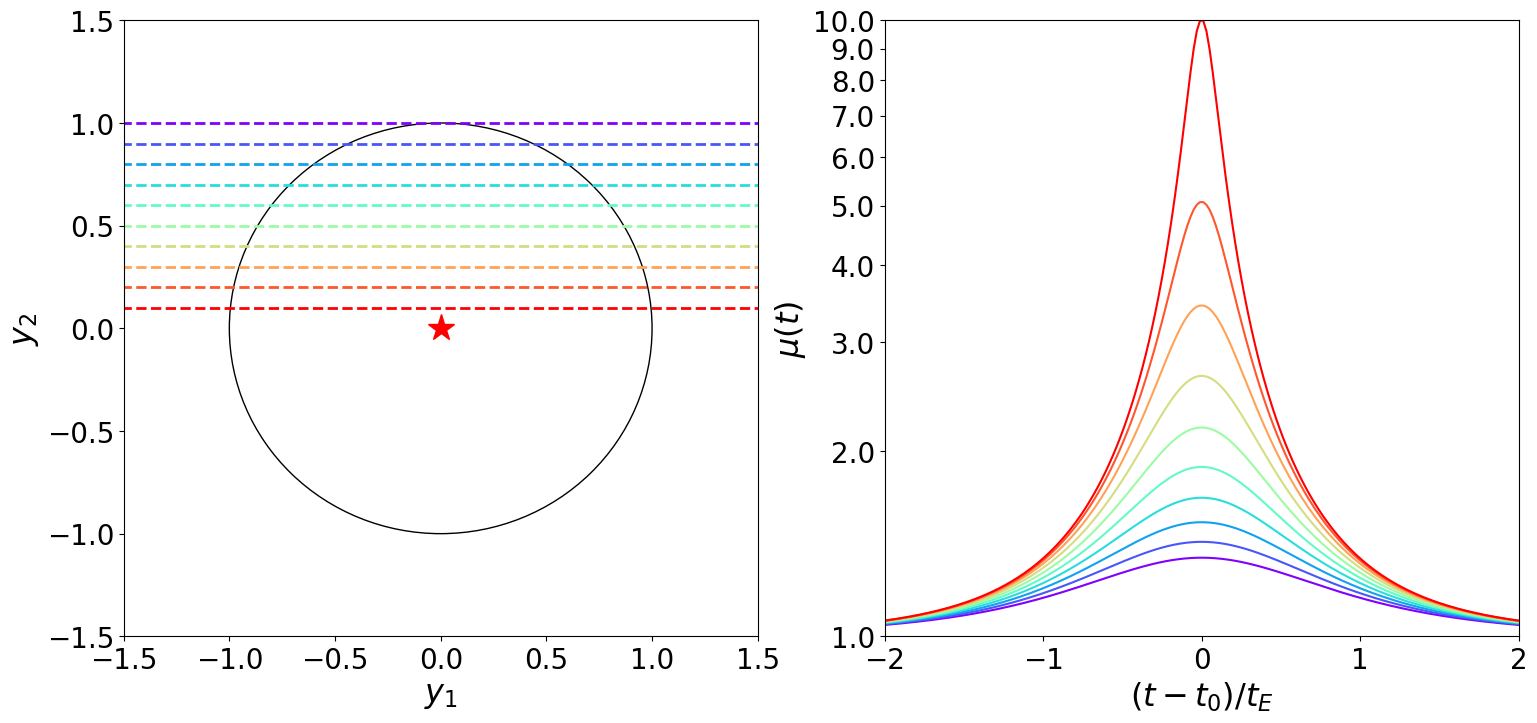

In [6]:
# loop over the impact parameters and calculate
# the lightcurves:

for i in range(y0.size):
    pl = point_lens(ps,mass=0.3,dl=4.0,t0=t0,y0=y0[i])
    t=pl.t0+np.linspace(-2,2,200)*pl.tE.value
    mut=pl.mut(t)


import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import cm 
import matplotlib.ticker as ticker

# create a color sequence using the rainbow color-map
color=iter(cm.rainbow(np.linspace(0,1,y0.size)))

xx=[-2,2]

fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[1].set_ylim([1.0,10.0])
ax[1].set_xlim([-2,2])
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$(t-t_0)/t_E$',fontsize=23)
ax[1].set_ylabel(r'$\mu(t)$',fontsize=23)
ax[1].set_yticks(np.arange(1, 11, 1.0))
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)

# create a circle with radius 1 (the Einstein ring)
circle=plt.Circle((0,0),1,color='black',fill=False)
ax[0].set_xlim([-1.5,1.5])
ax[0].set_ylim([-1.5,1.5])
ax[0].add_artist(circle) # display the Einstein ring
ax[0].plot([0.0],[0.0],'*',markersize=20,color='red')
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)

# loop over the impact parameters and plot the light curves
for i in range(y0.size):
    c=next(color)
    pl = point_lens(ps,mass=0.3,dl=4.0,t0=t0,y0=y0[i])
    t=pl.t0+np.linspace(-2,2,200)*pl.tE.value
    mut=pl.mut(t)
    ax[1].plot((t-pl.t0)/pl.tE,mut,'-',color=c)
    yy=[y0[i],y0[i]]
    ax[0].plot(xx,yy,'--',color=c,lw=2)

ax[0].set_xlabel(r'$y_1$',fontsize=23) 
ax[0].set_ylabel(r'$y_2$',fontsize=23)

To illustrate how the light curve changes as a function of other parameters, like the lens mass, the distance $D_L$, or the lens-source relative velocity $v_{rel}$, we must account for how $t_E$ depends on them:

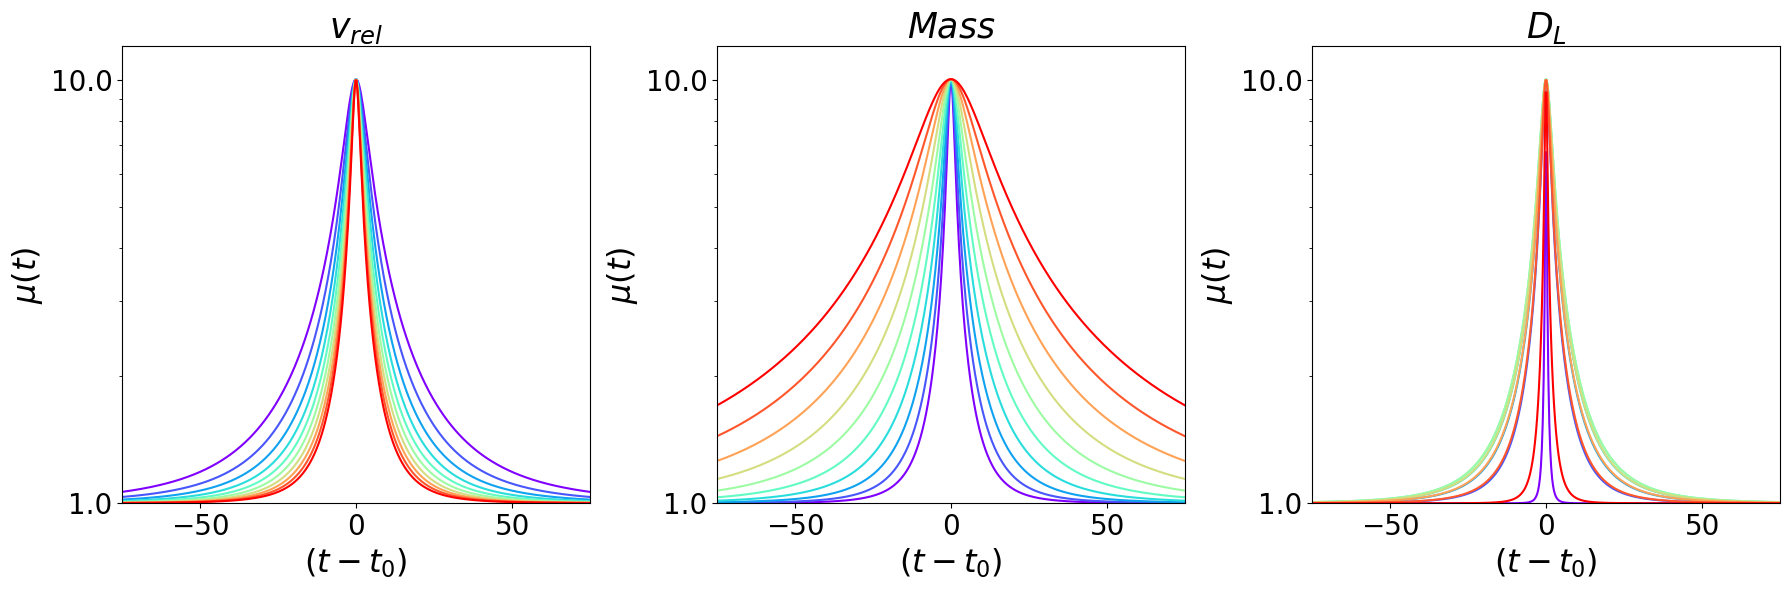

In [7]:
v_test=np.linspace(100.0,300.0,10)
M_test=np.logspace(-1,1,10)
d_test=np.linspace(0.01,8.0*0.99,10)


t=t0+np.linspace(-75,75,500)

fig,ax=plt.subplots(1,3,figsize=(18,6))

color=iter(cm.rainbow(np.linspace(0,1,v_test.size)))
for i in range(len(v_test)):
    ps = point_source(flux=1.,ds=8.0,vel=v_test[i])
    pl = point_lens(ps,mass=0.3,dl=4.0,t0=t0,y0=y0.min())
    t_=(t-t0)
    c=next(color)
    mut=pl.mut(t)
    ax[0].plot(t_,mut,'-',color=c)
    ax[0].set_title(r'$v_{rel}$',fontsize=25)
    
color=iter(cm.rainbow(np.linspace(0,1,v_test.size)))
ps = point_source(flux=1.,ds=8.0,vel=200)
for i in range(len(M_test)):
    pl = point_lens(ps,mass=M_test[i],dl=4.0,t0=t0,y0=y0.min())
    t_=(t-t0)
    c=next(color)
    mut=pl.mut(t)
    ax[1].plot(t_,mut,'-',color=c)
    ax[1].set_title(r'$Mass$',fontsize=25)
    
color=iter(cm.rainbow(np.linspace(0,1,v_test.size)))
for i in range(len(d_test)):
    pl = point_lens(ps,mass=0.3,dl=d_test[i],t0=t0,y0=y0.min())
    t_=(t-t0)
    c=next(color)
    mut=pl.mut(t)
    ax[2].plot(t_,mut,'-',color=c)
    ax[2].set_title(r'$D_{L}$',fontsize=25)        

for i in range(3):
    ax[i].xaxis.set_tick_params(labelsize=20)
    ax[i].yaxis.set_tick_params(labelsize=20)
    ax[i].set_yticks(np.arange(1, 11, 1.0))
    ax[i].set_xlabel(r'$(t-t_0)$',fontsize=23)
    ax[i].set_ylabel(r'$\mu(t)$',fontsize=23)
    ax[i].set_ylim([1.0,12.0])
    ax[i].set_xlim([t.min()-t0,t.max()-t0])
    ax[i].set_yscale('log')
    ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    
plt.tight_layout()


# Fitting the lightcurve

The microlensing lightcurve is defined by the parameters $t_0$, $y_0$, and $t_E$. This last quantity depends also on $M$, $v_{rel}$, $D_L$, and $D_S$. Besides, the lighcurve normalization depends on the baseline flux $f$. Once a microlensing event has been detected and the light-curve has been measured, how precisely can we measure all these parameters? 

Here, we set up the following experiment:

* we simulate the observation of a microlensing event and generate synthetic data, including measurement errors;
* we use the package ```lmfit``` to fit the data;
* we perform a bayesian analysis using the package ```emcee``` to estimate the posterior probability distributions of the parameters.

We assume that the lens has a mass of  $M=0.3 M_\odot$ and is at a distance of $D_L=4$ kpc. We further assume that the  source at a distance of $D_S=8$ kpc. The source baseline flux is $f=10$ (the units are arbitrary) and the impact parameter is $y_0=0.3$. The relative velocity of the source is $v=210$ km/s. We assume that we could monitor the source star for a long period (2 years) and collect data with constant cadence. This is clearly unrealistic, but we want to test a very ideal situation. In addition, we assume that the errors on the photometric measurement are at the level of $5\%$. The peak magnification occurs at $t_0=365$ days.

The code used to generate the synthetic data is here below. We use the classes ```point_source``` and ```point_lens``` from the previous example.  

(0.0, 730.0)

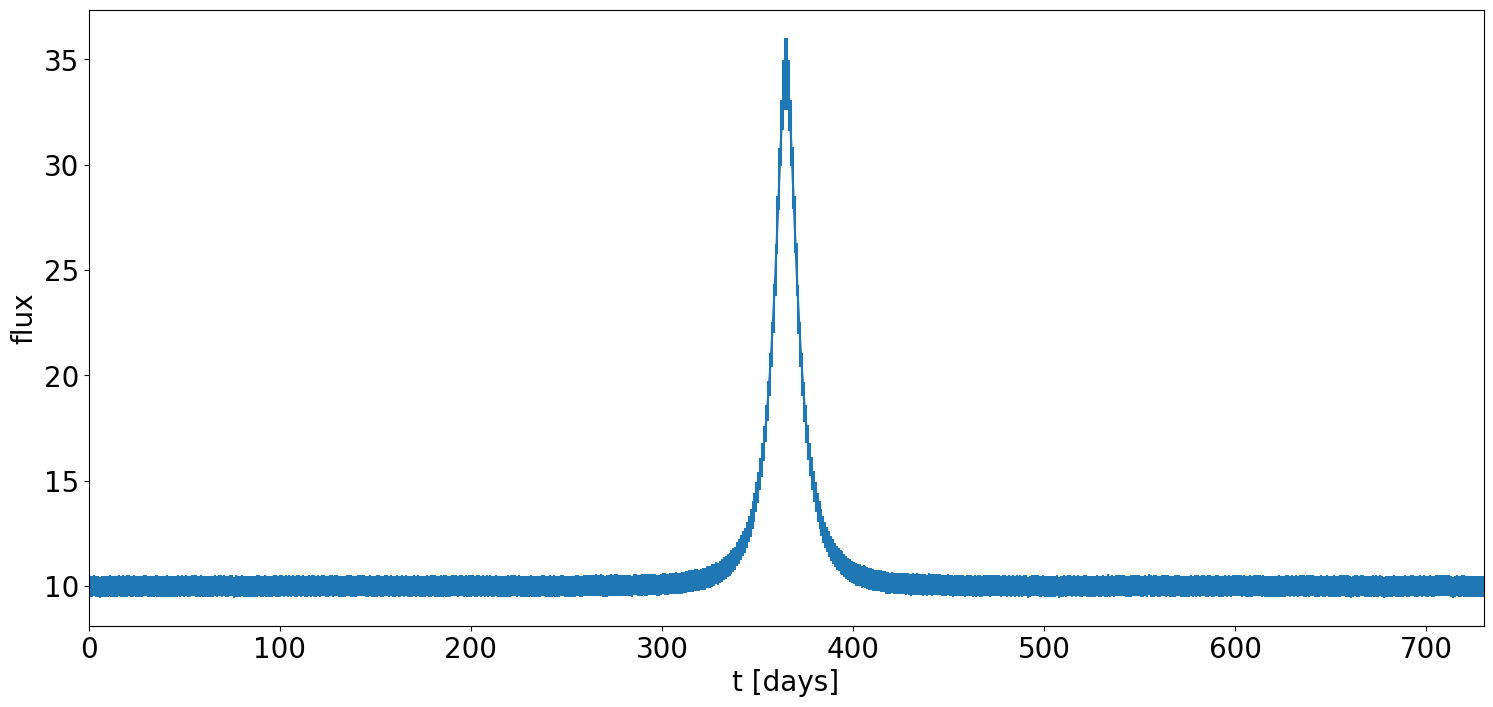

In [8]:
ps = point_source(flux=10.,ds=8.0,vel=210.)
pl = point_lens(ps,mass=0.3,dl=4.0,t0=365,y0=0.3)
t=np.linspace(0,730,730)
mut=pl.mut(t)+(np.random.randn(len(t))*0.02)

# we assign to the data some errors, which we assume to be a 
# constant fraction of the measurement
emut=mut*0.05

# data representation
fig,ax=plt.subplots(1,1,figsize=(18,8))
ax.errorbar(t, mut,emut)
ax.set_xlabel('t [days]',fontsize=20)
ax.set_ylabel('flux',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim([0,730])

The light-curve is displayed in the figure above (blue points with error bars).

As said, in order to fit the data, we use the python package ```lmfit```. This package allows to build complex fitting models for non-linear least-squares problems. The package documentation can be found at this [link](http://cars9.uchicago.edu/software/python/lmfit\_MinimizerResult/intro.html).

We begin by setting up some initial guesses for the model parameters, storing them in a {\tt lmfit.Parameter} object, including also some plausible ranges where the parameters can vary:

In [9]:
import lmfit

# initial guesses for the parameters:
# t0, M_lens, DL, DS, vel, y0, flux0
p = lmfit.Parameters()
p.add_many(('t0', 400.,True,0,720), ('M_lens', 1.0, True, 0.001, 100.0), 
           ('DL', 5., True, 0.1, 10.), ('DS', 8., False, 5., 15.), 
           ('vel',250,True,50.,300.), ('y0',0.8, True, 0.01,1.0),
           ('flux0',12, True, 8,12.0))
# For each parameter, we specify a initial value, a flag, two other values
# defining the search range. If the flag is True the parameter is free
# to vary, otherwise it is fixed to the initial value.

Then, we define a *cost* function to compare the data and the model:

In [10]:
def cost_function(p,t,mut,emut):
    ps = point_source(flux=p['flux0'],ds=p['DS'],vel=p['vel'])
    pl = point_lens(ps,mass=p['M_lens'],dl=p['DL'],
                    t0=p['t0'],y0=p['y0'])
    res=(pl.mut(t)-mut)**2/emut
    return (res)

This function returns the residuals between the model and the data.

The next step is to minimize the cost function (i.e. the residuals) to fit the data. Several algorithms are available in ```lmfit```. Here, we perform the minimization using the Nelder-Mead optimization method:

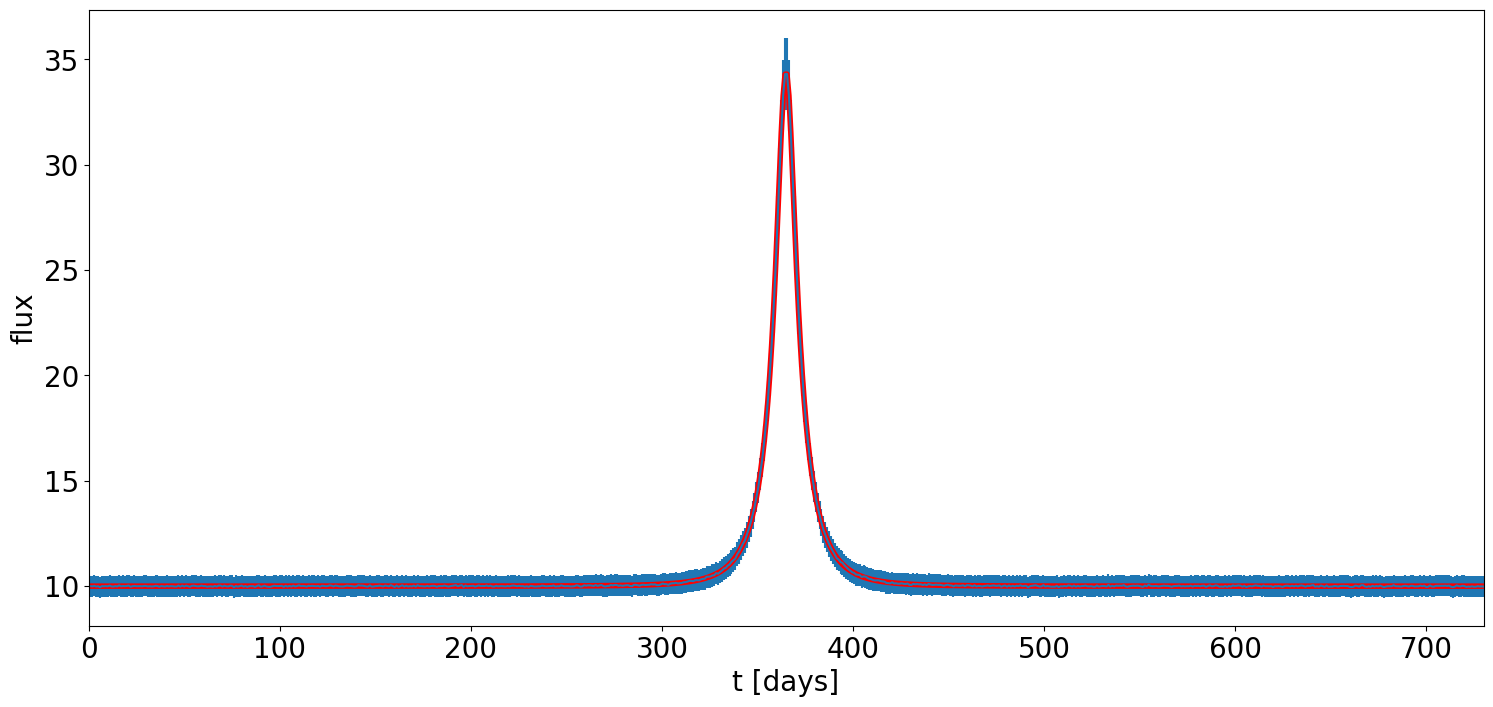

In [11]:
mi = lmfit.minimize(cost_function, p, method='Nelder',
                    args=(t,mut,emut))

# plot the maximum likelihood solution on the top of the data
fig,ax=plt.subplots(1,1,figsize=(18,8))
ax.errorbar(t, mut,emut)
ax.set_xlabel('t [days]',fontsize=20)
ax.set_ylabel('flux',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim([0,730])

ps_bf = point_source(flux=mi.params['flux0'],ds=mi.params['DS'],
                     vel=mi.params['vel'])
pl_bf = point_lens(ps_bf,mass=mi.params['M_lens'],dl=mi.params['DL'],
                   t0=mi.params['t0'],y0=mi.params['y0'])

ax.plot(t,pl_bf.mut(t),'r',lw=4)

The red line in the Figure above shows the best fit lightcurve. The best fit parameters are:

In [12]:
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)

[[Variables]]
    t0:      365.005629 (init = 400)
    M_lens:  0.56071025 (init = 1)
    DL:      4.95736906 (init = 5)
    DS:      8 (fixed)
    vel:     278.840156 (init = 250)
    y0:      0.30019886 (init = 0.8)
    flux0:   10.0008594 (init = 12)


The values of some of the input parameters are recovered almost perfectly: $t_0$, $y_0$, and $f$. Not surprisingly, the remaining parameters differ significanly from the truth. They are highly degenerate parameters, because they all concur to determine the value of $t_E$. Only the Einstein crossing time determines the shape of the light curve. 

We perform a Bayesian sampling of the posterior probability distribution of the parameters using the ```emcee``` Monte Carlo Markov Chain package (see e.g. [this link](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)). The log-posterior probability of the model parameters, $p$, given the data $d$ is
\begin{equation}
\ln P(p|d) \propto \ln P(d|p)+\ln P(p) \;,
\end{equation}
where $\ln P(d|p)$ is the log-likelihood of the data given the model parameters and $\ln P(p)$ is the log-prior. We assume a uniform prior, meaning that $\ln P$ is zero if all the parameters are inside the bounds, and $-\infty$ if any of the parameters is outside its limits.

The log-likelihood function is 
\begin{equation}
\ln P(d|p)=-\frac{1}{2}\sum_n \left[\frac{(model_n-data_n)^2}{s_n^2}+\ln 2\pi s_n^2\right] \;,
\end{equation}
where $s_n$ is the data uncertainty.

We calculate it as follows:

In [13]:
# log-likelihood function
def lnprob(p,t,mut,emut):
    from numpy import inf
    resid = cost_function(p,t,mut,emut)
    s = emut
    resid *= resid/s/s
    resid += np.log(2 * np.pi * s**2)
    lnp=-0.5 * np.sum(resid)
    return lnp

The next step is to call the function ```minimize``` using the method ```emcee```. We use 100 walkers to explore the parameter space. We run a few  *burn-in* steps in each MCMC chain to let the walkers get settled into the maximum of the density. Then, we do a production run of 2000 steps.

In [14]:
res = lmfit.minimize(lnprob, method='emcee',
                     nan_policy='omit', 
                     nwalkers=100, burn=500, steps=2000, 
                     params=mi.params,
                     progress=True,args=(t,mut,emut))

  5%|█▋                                  | 96/2000 [00:06<01:48, 17.49it/s]/Users/bmetcalf/opt/miniconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████████████████████████████| 2000/2000 [01:50<00:00, 18.18it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [128.95129666 159.53245676 193.97837615 148.5044246  128.59911332
 117.0141846 ]


Finally, we visualize the posterior probability distributions using the ```corner``` package. The function corner uses the samples saved in ``` res.flatchain``` to draw two-dimensional histograms showing the probability density in the planes defined by each couple of parameters. These 2D-histograms are very useful to highlight the existing correlations between $v_{rel}$, $D_L$, and $M$. Besides, ```corner``` also plots the marginalized one dimensional density distribution for each parameter.

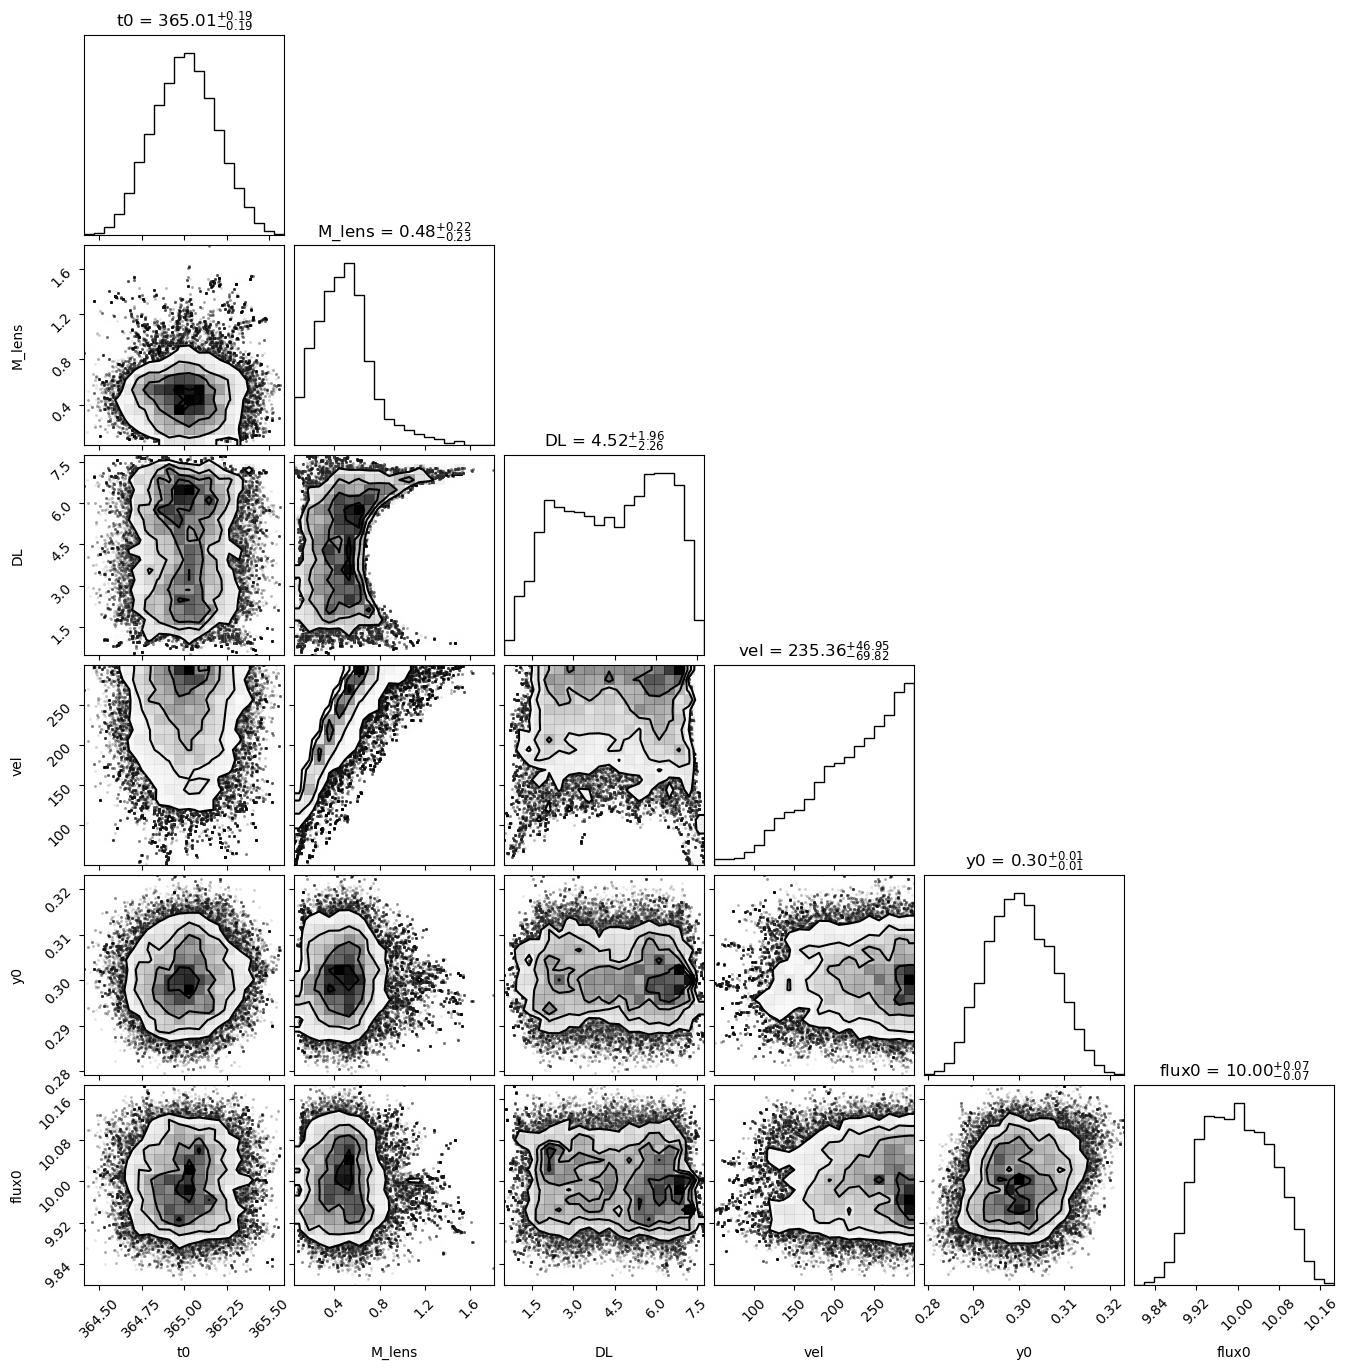

In [15]:
# show corner plot (confidence limits, parameter distributions, correlations)
import corner
#figure=corner.corner(res.flatchain, labels=res.var_names, 
#                     truths=list(res.params.valuesdict().values()),
#                     show_titles=True, title_kwargs={"fontsize": 12})

figure=corner.corner(res.flatchain, labels=res.var_names, 
                     show_titles=True, title_kwargs={"fontsize": 12})

We can now repeat the experiment by fitting $t_0$, $y_0$, $f$, and $t_E$:

[[Variables]]
    t0:     365.006137 (init = 360)
    tE:     18.2202586 (init = 20)
    y0:     0.30018877 (init = 0.2)
    flux0:  10.0008481 (init = 12)


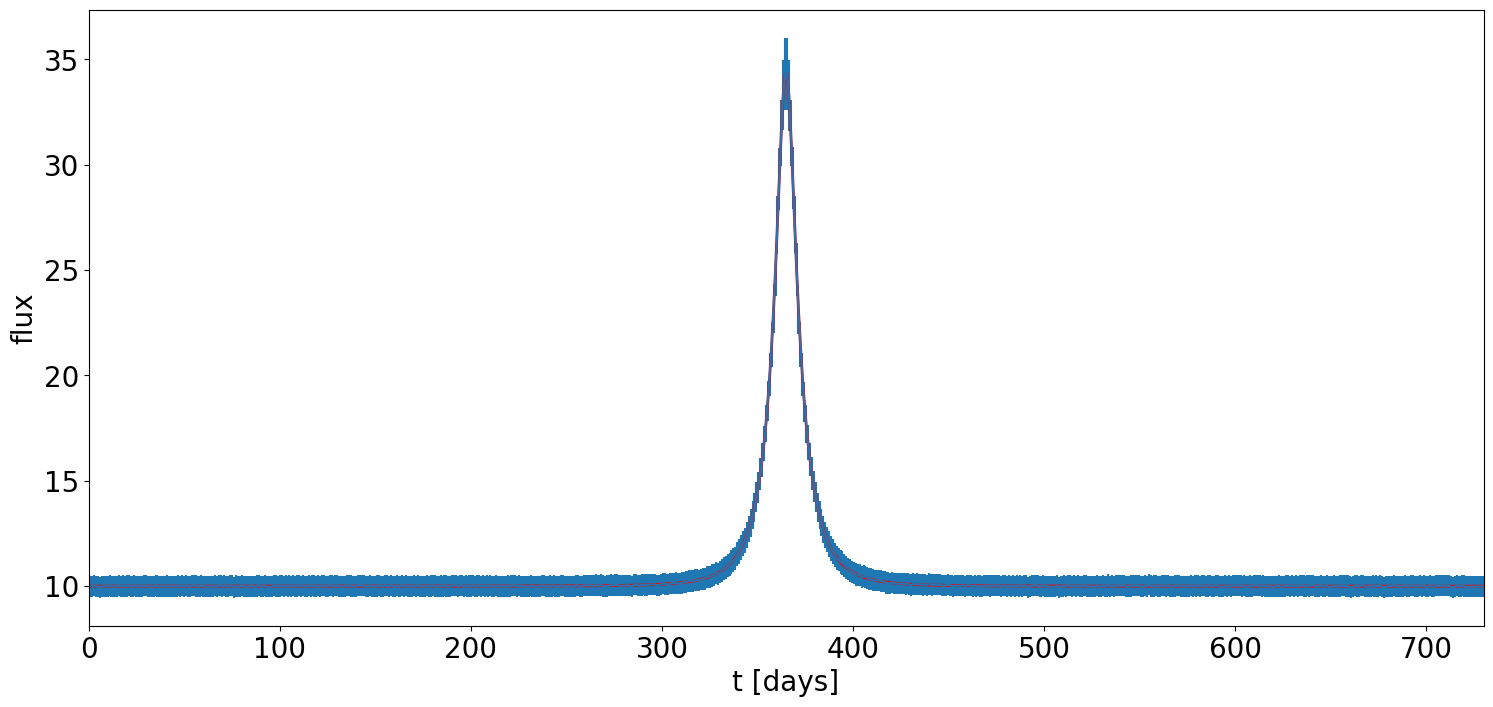

In [16]:
import lmfit

# initial guesses
p = lmfit.Parameters()
p.add_many(('t0', 360.,True,0,720), ('tE', 20, True, 1, 100.0), 
           ('y0',0.2, True, 0.01,1.0),('flux0',12, True, 8,12.0))

# new functions

def mut_func_new(tE,y0,t0,t):
    y=yt_new(tE,y0,t0,t)
    return ((y**2+2)/y/np.sqrt(y**2+4))

def yt_new(tE,y0,t0,t):
    return (np.sqrt(y0**2+((t-t0)/tE)**2))


# objective function
def new_cost_function(p,t,mut,emut):

    v = p.valuesdict()
    res=(mut_func_new(v['tE'],v['y0'],v['t0'],t)*v['flux0']-mut)**2/emut

    return (res)


mi = lmfit.minimize(new_cost_function, p, method='Nelder',
                    args=(t,mut,emut))
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)

fig,ax=plt.subplots(1,1,figsize=(18,8))
ax.errorbar(t, mut,emut)
ax.set_xlabel('t [days]',fontsize=20)
ax.set_ylabel('flux',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim([0,730])

ax.plot(t,mi.params['flux0']*mut_func_new(mi.params['tE'],
                                          mi.params['y0'],mi.params['t0'],t),'r',lw=2)

In [17]:
# new log-likelihood function
def new_lnprob(p,t,mut,emut):
    from numpy import inf
    resid = new_cost_function(p,t,mut,emut)
    s = emut
    resid *= resid/s/s
    resid += np.log(2 * np.pi * s**2)
    lnp=-0.5 * np.sum(resid)
    return lnp

result = lmfit.minimize(new_lnprob, method='emcee',
                     nan_policy='omit', 
                     nwalkers=100, burn=500, steps=2000, 
                     params=mi.params,
                     progress=True,args=(t,mut,emut))

100%|██████████████████████████████████| 2000/2000 [00:20<00:00, 97.91it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [51.72604776 48.82924782 47.42225957 46.90946701]


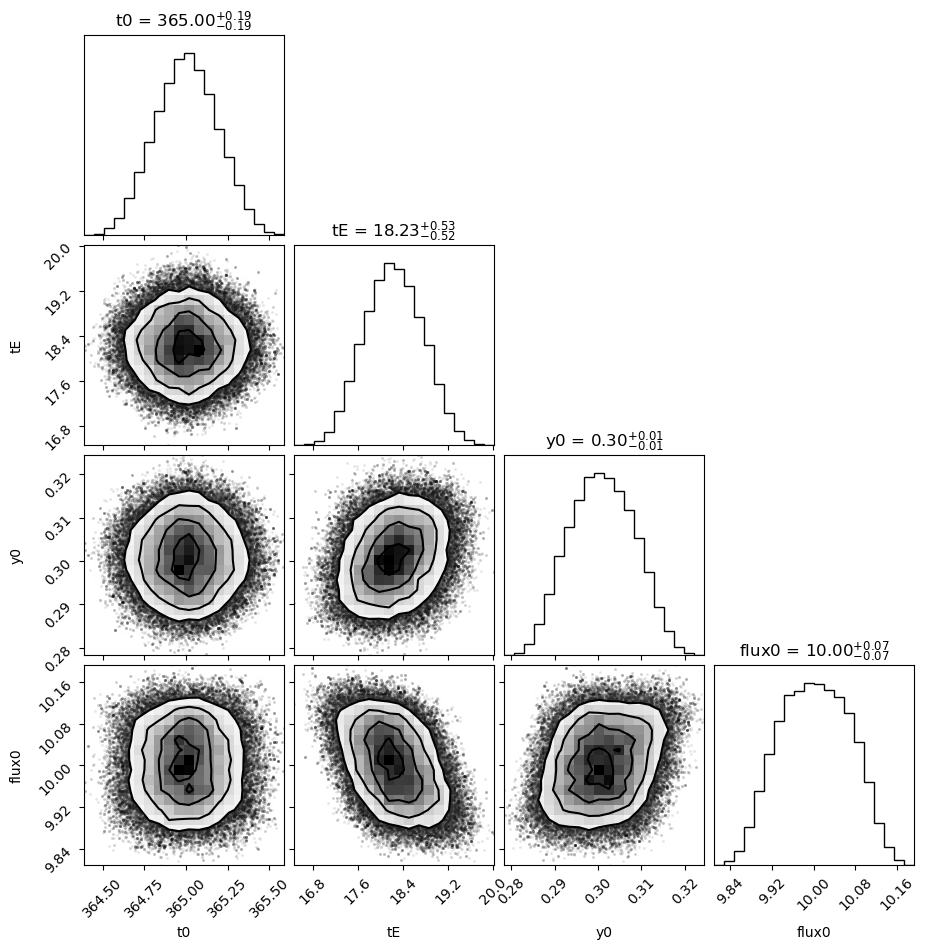

In [18]:
figure=corner.corner(res.flatchain, labels=res.var_names, 
                     show_titles=True, title_kwargs={"fontsize": 12})

res.params.pretty_print()

Clearly, all parameters are now recovered precisely and the correlations between them are negligible.

In [ ]:
import pandas as pd

#ps = point_source(flux=25.,ds=40.0,vel=90.)
#pl = point_lens(ps,mass=0.3,dl=4.0,t0=365,y0=0.3)
#t=  np.sort(np.random.uniform(low=0,high=700,size = 300))
#mut=pl.mut(t)
#emut=mut*0.05
#mut = mut + (np.random.randn(len(t))*emut)
#df = pd.DataFrame({'time':t,'flux':mut,'error':emut})
#df.to_csv('microlen_lightcurve.csv',index=False)

Here we read in a new lightcurve and assign the measured time, flux and error in the flux to the same variables used above. 

In [38]:
df = pd.read_csv('microlens_lightcurve.csv')
print(df.head())

t = df['time']
mut = df['flux']
emut = df['error']

       time       flux     error
0  4.158221  26.173542  1.251414
1  4.811229  23.622270  1.251423
2  4.828913  23.931002  1.251424
3  4.890593  23.046816  1.251425
4  5.980401  25.518039  1.251441


Now we can make a plot of the data.

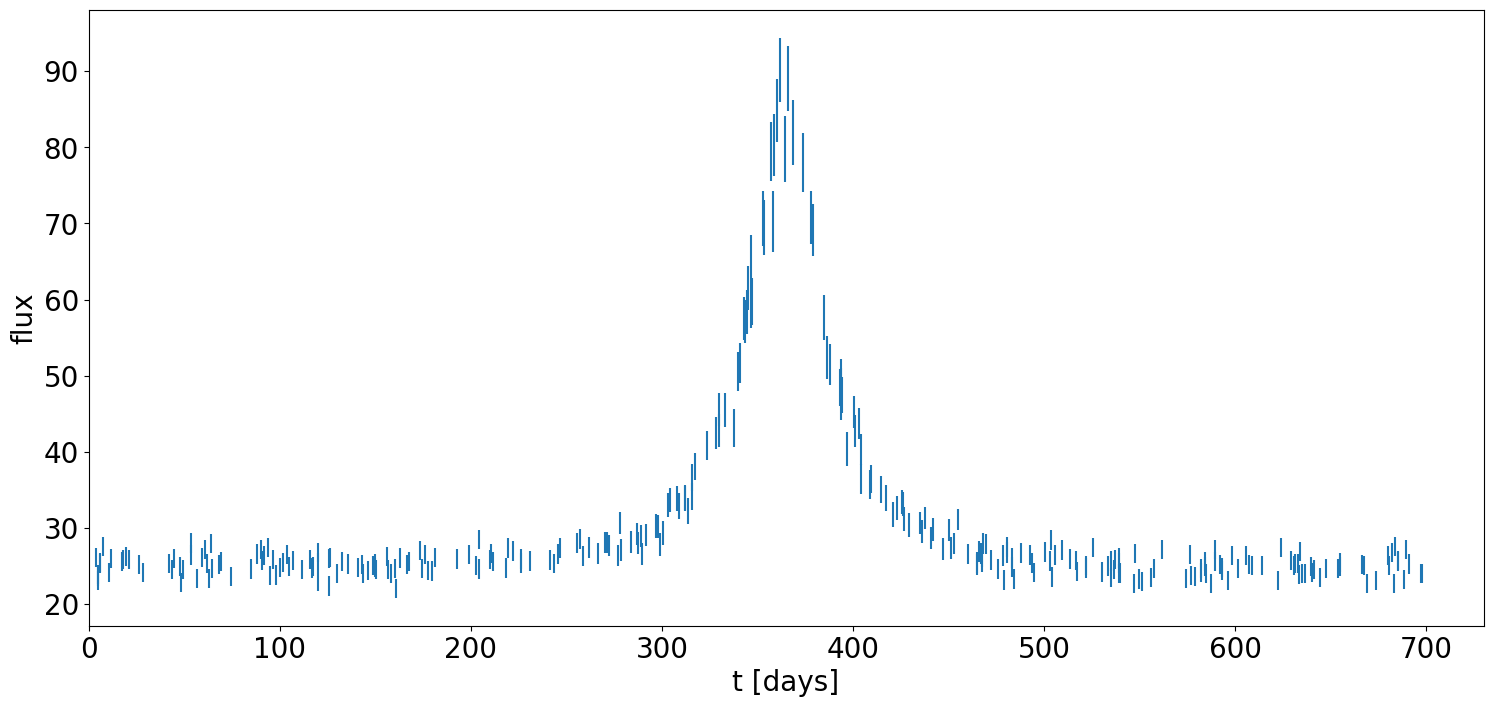

In [39]:

fig,ax=plt.subplots(1,1,figsize=(18,8))
ax.errorbar(t, mut,emut,linestyle='')
ax.set_xlabel('t [days]',fontsize=20)
ax.set_ylabel('flux',fontsize=20)

ax.set_ylabel('flux',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim([0,730])

plt.show()

We can find the best-fit parameters as follows.  We need to remake the parameter object with new guesses and ranges.  Then we can minimize the lose function.

In [40]:
p = lmfit.Parameters()
p.add_many(('t0', 360.,True,0,720), ('tE', 100, True, 1, 300.0), 
           ('y0',0.3, True, 0.01,1.0),('flux0',25, True, 0,30))

mi = lmfit.minimize(new_cost_function, p, method='Nelder',
                    args=(t,mut,emut))
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)

[[Variables]]
    t0:     365.121643 (init = 360)
    tE:     56.4503664 (init = 100)
    y0:     0.30666914 (init = 0.3)
    flux0:  24.9719167 (init = 25)


Now we can find the errors and covariances for the parameters using Markov Chain Monte Carlo (MCMC).

In [ ]:
res = lmfit.minimize(new_lnprob, method='emcee',
                     nan_policy='omit', 
                     nwalkers=100, burn=100, steps=2000, 
                     params=mi.params,
                     progress=True,args=(t,mut,emut))

figure=corner.corner(res.flatchain, labels=res.var_names, 
                     show_titles=True, title_kwargs={"fontsize": 12})

res.params.pretty_print()

 98%|█████████████████████████████████▎| 4893/5000 [16:50<00:21,  5.05it/s]